量子ソフトウェア勉強会第13回目:「量子インスパイアード古典アルゴリズム」ハンズオン資料 1  
2022年10月7日(金)  
高比良宗一

# $\mathrm{SQ}(A)$と$\mathrm{SQ}(b)$の実装について
このノートブックでは，SQデータ構造を実装します．
最初にセグメント木構造を実装します．次に，それを用いてベクトルに基づくデータ構造$\mathrm{SQ}(v)$を実装します．その後に行列に基づくデータ構造$\mathrm{SQ}(A)$を，ベクトルに基づくデータ構造を用いて実装します．
$$
%  ![image.png](attachment:image.png)
\newcommand{\abs}[1]{|#1|}
\newcommand{\norm}[1]{\lVert#1\rVert}
$$

In [2]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

## セグメント木構造の実装
[セグメント木構造](https://en.wikipedia.org/wiki/Segment_tree)は，次のセルのように実装できます．

In [3]:
class SegmentTree:
    def __init__(self, n):
        self.size   = 2**(math.ceil(math.log2(n)) + 1)
        self.height = math.ceil(math.log2(n))
        self.data   = np.zeros(self.size)

    def root(self):
        return self.data[1] 
               
    def leaf(self, i):
        index = self.size//2 + i
        return self.data[index]
    
    def update(self, k, val):
        size = self.size
        for _ in (range(self.height+1)):
            size = size//2
            self.data[size + k] += val
            k = k // 2 
            
    def __str__(self):
        return str(self.data)

## ベクトルに関するデータ構造 $\mathrm{SQ}(v)$ の実装
セグメント木構造を用いて，ベクトルに基づいたデータ構造$\mathrm{SQ}(v)$を実装します．簡単のために実ベクトルのみを扱います．

### 定義
$\mathrm{SQ}(v)$の定義は下記の通りです．

ベクトル$v \in \mathbb{C}^n$に対して，$\mathrm{SQ}(v)$を次の操作(1-3)が行えるようなデータ構造とする．([2.](https://dl.acm.org/doi/10.1145/3357713.3384314)のDefinition 2.5や[3.](https://quantum-journal.org/papers/q-2022-06-30-754/)のDefinition 1.1など)
- $\text{Sample}()$.  確率$\abs{v_i}^2/\norm{v}^2$で添字$i$を出力する
- $\text{Query}(i)$. ベクトルの第$i$成分を出力する
- $\text{Norm}()$. ベクトルの2ノルム$\norm{v}$を出力する  

### 実装

In [4]:
class VectorBasedDataStructure:    
    def __init__(self, vector):
        self.n = vector.size
        self.segment_tree = SegmentTree(self.n)
        self.sgn = np.sign(vector)
        for i in range(self.n):
            self.segment_tree.update(i, abs(vector[i])**2)
            
    def sample(self):
        return self._sample2()
                            
    def _sample1(self):
        height = self.segment_tree.height    
        size   = self.segment_tree.size
        k = 1
        for _ in range(height):
            if random.random() < self.segment_tree.data[2*k]/self.segment_tree.data[k]:
                k = 2*k
            else:
                k = 2*k+1
        return k - size//2
    
    def _sample2(self):
        height = self.segment_tree.height    
        size   = self.segment_tree.size
        k = 1
        for _ in range(height):
            if random.random()*self.segment_tree.data[k] < self.segment_tree.data[2*k]:
                k = 2*k
            else:
                k = 2*k+1
        return k - size//2    
    
    def query(self, i):
        val = self.segment_tree.leaf(i)
        return self.sgn[i]*math.sqrt(val)    
            
    def norm(self):
        return math.sqrt(self.segment_tree.root())
    
    def print_structure(self):
        data = self.segment_tree.data
        height = self.segment_tree.height
        print("height =", height)
        k = 1
        for i in range(height+1):
            lst = []
            for j in range(2**i,2**(i+1)):  
                lst.append(data[j])
            print(lst)   
        print(self.sgn)

### 確認
上のセルの`VectorBasedDataStructure`が$\mathrm{SQ}(v)$を実装できているか確認します．
各関数$\mathrm{Norm}(), \mathrm{Query}(i), \mathrm{Sample}()$それぞれについて確認していきます．

In [5]:
import numpy as np
n = 10
v = np.random.rand(n) - np.random.rand(n)
SQv = VectorBasedDataStructure(v)

In [6]:
SQv.print_structure()

height = 4
[2.120901804620469]
[2.0975887317480506, 0.023313072872418364]
[0.139778771605787, 1.9578099601422638, 0.023313072872418364, 0.0]
[0.08036850697945108, 0.05941026462633593, 0.8641459326645209, 1.093664027477743, 0.023313072872418364, 0.0, 0.0, 0.0]
[0.018301360350497137, 0.06206714662895395, 0.03737714446339606, 0.022033120162939873, 0.03560276152483325, 0.8285431711396877, 0.8181854663602242, 0.2754785611175187, 6.490920279708548e-05, 0.023248163669621277, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-1.  1. -1.  1.  1. -1. -1.  1.  1. -1.]


#### $\mathrm{Norm}()$について
ベクトルの2ノルムが計算できているかどうか，NumPyの結果と比較をして確認してみます．

In [7]:
val = SQv.norm()
normv = np.linalg.norm(v, 2)

print(f"SQv.norm() = {val},\nnumpy.linalg.norm(v) = {normv}")

SQv.norm() = 1.4563316259082162,
numpy.linalg.norm(v) = 1.4563316259082162


#### $\mathrm{Query}(i)$について
全ての$i$に対して，元々のベクトル$v$の$i$番目の成分と比較をしてみます．

In [8]:
for i in range(n):
    val = SQv.query(i) 
    vi  = v[i]
    print(f"SQv.query({i}) = {val}, v_{i} = {vi}")
    
test_vector = np.array([SQv.query(i) for i in range(n)])
np.allclose(test_vector, v)

SQv.query(0) = -0.13528252049136702, v_0 = -0.13528252049136702
SQv.query(1) = 0.24913278914858628, v_1 = 0.24913278914858628
SQv.query(2) = -0.19333169544437367, v_2 = -0.19333169544437367
SQv.query(3) = 0.14843557579953626, v_3 = 0.14843557579953626
SQv.query(4) = 0.18868694052539314, v_4 = 0.18868694052539314
SQv.query(5) = -0.9102434680565896, v_5 = -0.9102434680565896
SQv.query(6) = -0.904536050337533, v_6 = -0.904536050337533
SQv.query(7) = 0.5248605158682816, v_7 = 0.5248605158682816
SQv.query(8) = 0.008056624776982324, v_8 = 0.008056624776982324
SQv.query(9) = -0.15247348513633863, v_9 = -0.15247348513633863


True

#### $\mathrm{Sample}()$について
`SQv.sample()`を何度も実行して得られた結果と，真の確率分布$\mathcal{D}_v (\Pr(i) = |v_i|^2/\norm{v}^2)$とを比較します．

SQ(v) [9.500e-03 2.900e-02 1.660e-02 8.800e-03 1.690e-02 3.810e-01 3.920e-01
 1.351e-01 2.000e-04 1.090e-02]
exact [8.62904653e-03 2.92645074e-02 1.76232320e-02 1.03885621e-02
 1.67866148e-02 3.90656073e-01 3.85772441e-01 1.29887466e-01
 3.06045299e-05 1.09614522e-02]
error = 0.012792073328308338


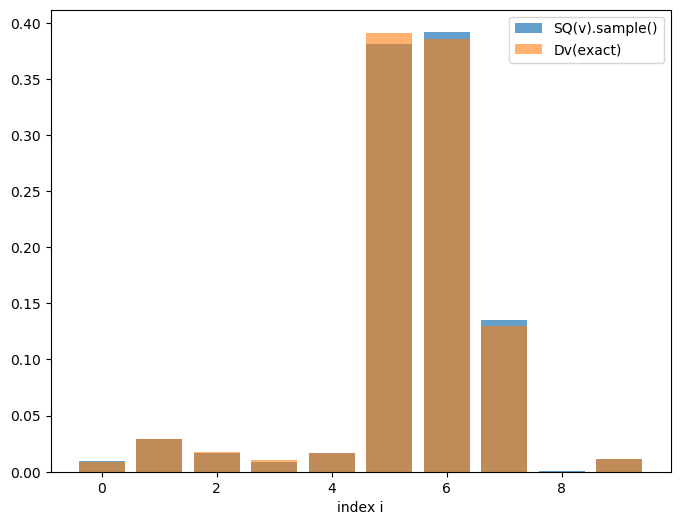

In [9]:
normv = np.linalg.norm(v, 2)
Dv = np.array([abs(v[i])**2/normv**2 for i in range(n)])

counts = np.zeros(n)

sample_size = 10000
for _ in range(sample_size):
    i = SQv.sample() 
    counts[i] += 1

print("SQ(v)", counts/sample_size)
print("exact", Dv)

print("error =", np.linalg.norm(Dv - counts/sample_size))

plt.figure(figsize=(8,6))
plt.bar(range(n), counts/sample_size, alpha=0.7, label="SQ(v).sample()")
plt.bar(range(n), Dv                , alpha=0.6, label="Dv(exact)")

plt.legend()
plt.xlabel("index i")
plt.show()

グラフの青色は$\mathrm{SQ}(v)$の結果を表し，オレンジ色は真の分布$\mathcal{D}_v$を表します．視覚的に見て大体同じであることを確認できると思います．

## 行列に基づくデータ構造 $\mathrm{SQ}(A)$ の実装
$\mathrm{SQ}(v)$について実装しました．これを用いて$\mathrm{SQ}(A)$を実装します．
簡単のために実行列のみを扱います．

### 定義

行列$A \in \mathbb{C}^{m \times n}$に対して，$\mathrm{SQ}(A)$を次の操作(1-5)が行えるようなデータ構造とする．([2.](https://dl.acm.org/doi/10.1145/3357713.3384314)のDefinition 2.10や[3.](https://quantum-journal.org/papers/q-2022-06-30-754/)のDefinition 1.2など)
- $\text{Sample1}()$. 確率$\norm{A_{i,\ast}}^2/\norm{A}_\mathrm{F}^2$で行添字$i$を出力する
- $\text{Sample2}(i)$. 確率$\abs{A_{ij}}^2/\norm{A_{i,\ast}}^2$で列添字$j$を出力する
- $\text{Query}(i,j)$.  第$(i,j)$成分$A_{ij}$を出力する
- $\text{Norm}(i)$. 第$i$行の2ノルム$\norm{A_{i,\ast}}$を出力する
- $\text{Norm}()$.  フロべニウスノルム$\norm{A}_\mathrm{F}$を出力する


### 実装
`VectorBasedDataStructure`を用いて$\mathrm{SQ(A)}$を実装します．

In [10]:
class MatrixBasedDataStructure:
    def __init__(self, matrix):
        self.m, self.n = matrix.shape
        self.shape = matrix.shape
        
        self.vecFro = np.array([np.linalg.norm(matrix[i,:]) for i in range(self.m)])
        self.SQvecFro = VectorBasedDataStructure(self.vecFro)
        self.SQrowlist = [VectorBasedDataStructure(matrix[i,:]) for i in range(self.m)]
            

    def sample1(self):
        return self.SQvecFro.sample()

    def sample2(self, i):
        return self.SQrowlist[i].sample()
    
    def query(self, i, j):
        return self.SQrowlist[i].query(j)
    
    def norm(self, i):
        return self.SQrowlist[i].norm()
    
    def normF(self):
        return self.SQvecFro.norm()

### 確認

上のセルの`MatrixBasedDataStructure`が$\mathrm{SQ}(A)$を実装できているか確認します．
各関数$\mathrm{Sample1}()$, $\mathrm{Sample2}()$, $\mathrm{Query}()$, $\mathrm{Norm}(i)$, $\mathrm{Norm}()$ (`normF`), それぞれ確認していきます．

In [11]:
m, n = 8, 16
A = np.random.rand(m, n) - np.random.rand(m, n)
SQA = MatrixBasedDataStructure(A)

#### $\mathrm{Sample1}()$について
`SQA.sample1()`を何度も実行して得られた結果と，真の確率分布$\Pr(i) = \norm{A_{i,\ast}}^2/\norm{A}_\mathrm{F}^2$とを比較します．

SQ(A).sample1()
 [0.1074 0.1594 0.056  0.1202 0.1715 0.1518 0.116  0.1177]
exact
 [0.10282038 0.15322317 0.05685199 0.12203012 0.17638788 0.15067793
 0.1183215  0.11968703]
error = 0.009883797274048613


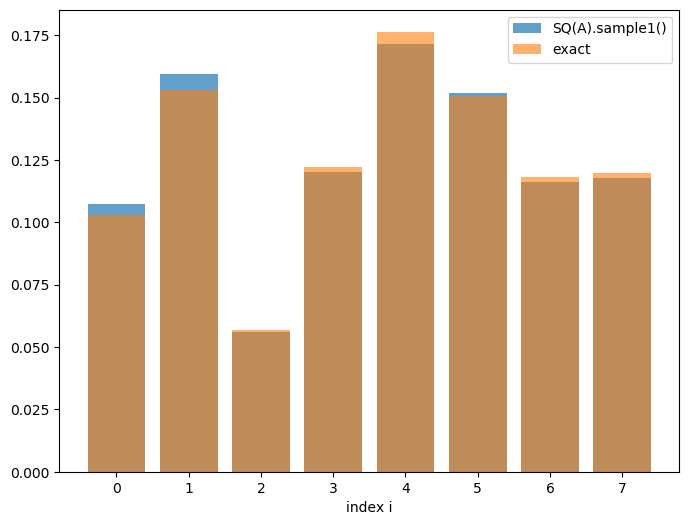

In [12]:
normAF = np.linalg.norm(A) # Aのフロべニウスノルム
Da = np.array([np.linalg.norm(A[i,:])**2/normAF**2 for i in range(m)])

sample_size = 10000
counts = np.zeros(m)
for _ in range(sample_size):
    i = SQA.sample1()
    counts[i] += 1

print("SQ(A).sample1()\n", counts/sample_size)
print("exact\n", Da)
print("error =", np.linalg.norm(Da - counts/sample_size))

plt.figure(figsize=(8,6))

plt.bar(range(m), counts/sample_size, alpha=0.7, label="SQ(A).sample1()")
plt.bar(range(m), Da,                 alpha=0.6, label="exact")

plt.legend()
plt.xlabel("index i")
plt.show()

#### $\mathrm{Sample2}(i)$について
$\mathrm{Sample2}(i)$について確認します．$i = 0,1,2,\dots,m-1$の全てを調査すると図がたくさん表示されるので，
図については$i=0,1,2$までを見ます．
`SQA.sample2()`を何度も実行して得られた結果と，真の確率分布$\Pr(j) = |A_{i,j}|^2/\norm{A_{i,\ast}}^2)$とを比較します．

--------- i = 0 ----------
SQ(A).sample2(0):
 [0.026 0.008 0.    0.04  0.012 0.137 0.064 0.06  0.035 0.071 0.04  0.072
 0.38  0.005 0.017 0.033]
exact:
 [2.61589305e-02 5.43838777e-03 7.12260289e-05 4.09045050e-02
 1.17076758e-02 1.46687110e-01 7.63977358e-02 5.58589520e-02
 3.49893460e-02 6.01797400e-02 3.03242259e-02 7.79174672e-02
 3.77870925e-01 4.13006695e-03 2.00947909e-02 3.12689151e-02]
error = 0.023146647598591138


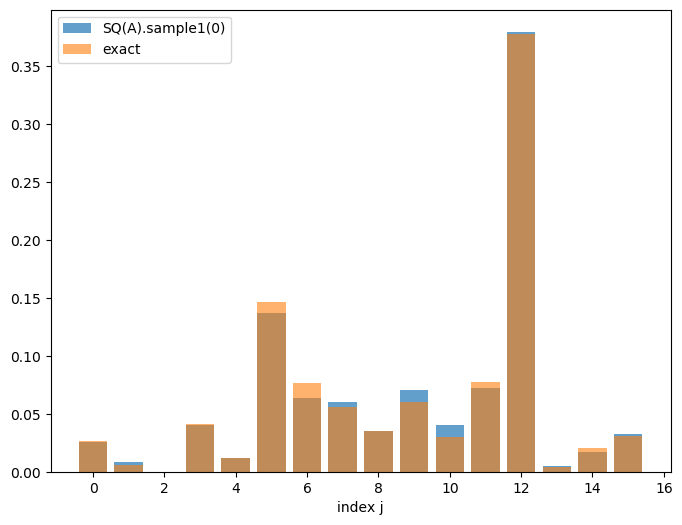

--------- i = 1 ----------
SQ(A).sample2(1):
 [0.15  0.218 0.182 0.058 0.011 0.071 0.002 0.007 0.168 0.028 0.006 0.001
 0.001 0.047 0.049 0.001]
exact:
 [0.15364116 0.20022576 0.17234216 0.05975188 0.01254292 0.07700894
 0.00165842 0.00705121 0.17524188 0.01733796 0.00318492 0.00348038
 0.00062585 0.05626658 0.05836748 0.00127251]
error = 0.02860360503672554


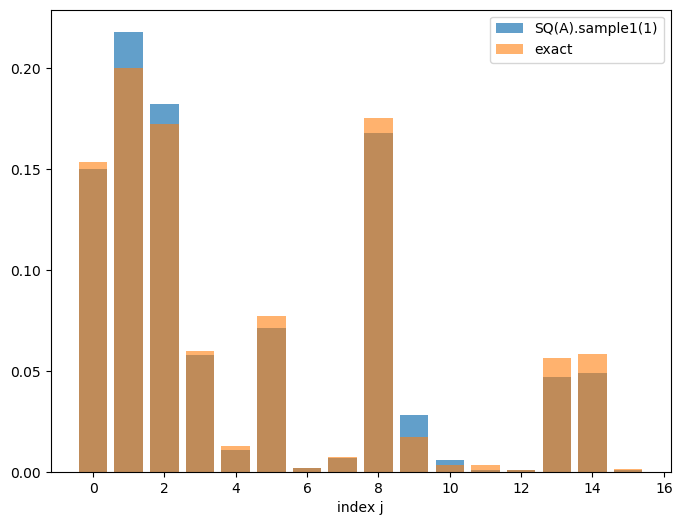

--------- i = 2 ----------
SQ(A).sample2(2):
 [0.267 0.029 0.047 0.077 0.    0.036 0.134 0.012 0.004 0.02  0.006 0.039
 0.008 0.005 0.316 0.   ]
exact:
 [2.97310594e-01 3.49424249e-02 4.43479664e-02 7.87117376e-02
 1.04588378e-03 2.84099189e-02 1.22766266e-01 1.07283563e-02
 1.66576306e-03 1.30660945e-02 3.24114925e-03 4.10916978e-02
 1.07398985e-02 4.51190733e-03 3.07415815e-01 4.52714206e-06]
error = 0.0360204468989882


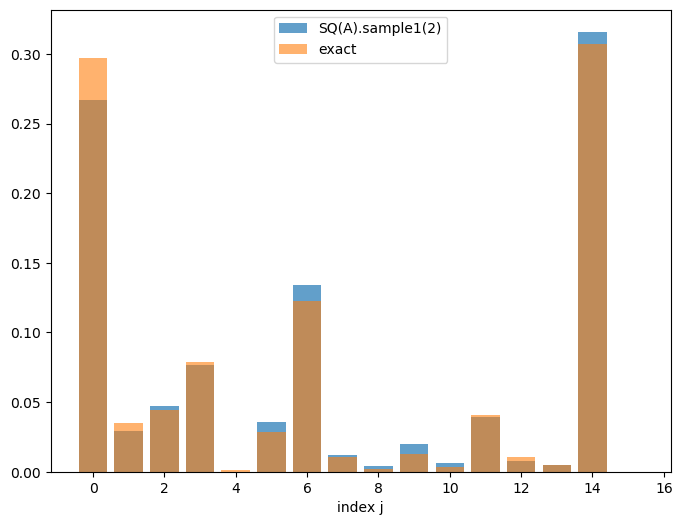

--------- i = 3 ----------
SQ(A).sample2(3):
 [0.121 0.012 0.014 0.134 0.022 0.12  0.013 0.041 0.03  0.112 0.09  0.007
 0.009 0.018 0.059 0.198]
exact:
 [0.12650471 0.01124571 0.0137039  0.14462051 0.02122042 0.12634149
 0.01084034 0.03499785 0.02977037 0.10949382 0.09215462 0.0076607
 0.00889631 0.01949074 0.05797309 0.18508543]
error = 0.020168095562929002
--------- i = 4 ----------
SQ(A).sample2(4):
 [0.083 0.019 0.115 0.05  0.033 0.003 0.02  0.105 0.039 0.155 0.069 0.124
 0.096 0.041 0.001 0.047]
exact:
 [0.08606608 0.0265392  0.10741687 0.06293396 0.02962027 0.00079901
 0.0223592  0.09870016 0.04926015 0.16711282 0.04760761 0.11911806
 0.09701586 0.03398356 0.00125728 0.05020992]
error = 0.03386211981035436
--------- i = 5 ----------
SQ(A).sample2(5):
 [0.092 0.004 0.003 0.022 0.158 0.031 0.006 0.138 0.139 0.013 0.012 0.117
 0.16  0.095 0.001 0.009]
exact:
 [0.09144526 0.00160718 0.0048929  0.02824854 0.16411036 0.03155316
 0.00428561 0.14134491 0.14548735 0.0131875  0.0144568  0.

In [13]:
sample_size = 1000
for i in range(m):  
    normAi = np.linalg.norm(A[i,:])
    Dai = np.array([abs(A[i,j])**2/normAi**2 for j in range(n)])
    
    counts = np.zeros(n)
    for _ in range(sample_size):
        j = SQA.sample2(i)
        counts[j] += 1
        
    print(f"--------- i = {i} ----------")    
    print(f"SQ(A).sample2({i}):\n", counts/sample_size)
    print("exact:\n", Dai)
    print("error =", np.linalg.norm(Dai - counts/sample_size))

    if i < 3: 
        plt.figure(figsize=(8,6))
        plt.bar(range(n), counts/sample_size, alpha=0.7, label=f"SQ(A).sample1({i})")
        plt.bar(range(n), Dai, alpha=0.6, label="exact")
        plt.legend()
        plt.xlabel("index j")
        plt.show()

#### $\mathrm{Query}(i,j)$について
全ての$i,j$に対して，元々の行列$A$の$i,j$番目の成分と比較をしていきます．

In [14]:
for i in range(m):
    for j in range(n):
        val = SQA.query(i,j)
        Aij = A[i, j]
        print(f"SQA.query({i},{j}) = {val}, A[{i},{j}] = {Aij}")

test_matrix = np.array([[SQA.query(i,j) for j in range(n)] for i in range(m)])
np.allclose(test_matrix, A)

SQA.query(0,0) = 0.24673634912174847, A[0,0] = 0.24673634912174847
SQA.query(0,1) = 0.11250147779193254, A[0,1] = 0.11250147779193254
SQA.query(0,2) = 0.012874859784769876, A[0,2] = 0.012874859784769876
SQA.query(0,3) = -0.30853803765666965, A[0,3] = -0.30853803765666965
SQA.query(0,4) = 0.16506632668228316, A[0,4] = 0.16506632668228316
SQA.query(0,5) = -0.584277440516464, A[0,5] = -0.584277440516464
SQA.query(0,6) = -0.42166095282004157, A[0,6] = -0.42166095282004157
SQA.query(0,7) = 0.3605533487658288, A[0,7] = 0.3605533487658288
SQA.query(0,8) = 0.28535865845082664, A[0,8] = 0.28535865845082664
SQA.query(0,9) = 0.3742383549700018, A[0,9] = 0.3742383549700018
SQA.query(0,10) = 0.26565500570949485, A[0,10] = 0.26565500570949485
SQA.query(0,11) = 0.4258342170488666, A[0,11] = 0.4258342170488666
SQA.query(0,12) = 0.9377668588378694, A[0,12] = 0.9377668588378694
SQA.query(0,13) = -0.09803963553172723, A[0,13] = -0.09803963553172723
SQA.query(0,14) = 0.21625436799722275, A[0,14] = 0.21625

True

#### $\mathrm{Norm}(i)$について
行列$A$の各列ベクトル$A_{0,\ast},\dots,A_{m,\ast}$の2ノルムが計算できているかどうか，NumPyの関数を用いた時の結果と比較をして確認してみます．

In [15]:
for i in range(m):
    val    = SQA.norm(i)
    normAi =  np.linalg.norm(A[i,:])
    print(f"SQ(A).norm({i}) = {val} \t, np.linalg.norm(Ai) = {normAi}")

SQ(A).norm(0) = 1.525538393413868 	, np.linalg.norm(Ai) = 1.525538393413868
SQ(A).norm(1) = 1.862283338358721 	, np.linalg.norm(Ai) = 1.8622833383587214
SQ(A).norm(2) = 1.1343742611231984 	, np.linalg.norm(Ai) = 1.1343742611231982
SQ(A).norm(3) = 1.6619465991868285 	, np.linalg.norm(Ai) = 1.6619465991868285
SQ(A).norm(4) = 1.9981031627183627 	, np.linalg.norm(Ai) = 1.9981031627183625
SQ(A).norm(5) = 1.846751079073428 	, np.linalg.norm(Ai) = 1.8467510790734278
SQ(A).norm(6) = 1.6364975773818458 	, np.linalg.norm(Ai) = 1.6364975773818458
SQ(A).norm(7) = 1.6459138082844538 	, np.linalg.norm(Ai) = 1.6459138082844536


#### $\mathrm{Norm}()$について
行列のフロべニウスノルムが計算できているかどうか，NumPyの関数を用いた時の結果と比較をして確認してみます．

In [16]:
print("SQ(A) norm()  ", SQA.normF())
print("Frobenius norm", np.linalg.norm(A))

SQ(A) norm()   4.7575519405423
Frobenius norm 4.7575519405423


## まとめ
$\mathrm{SQ}(v), \mathrm{SQ}(A)$をそれぞれ`VectorBasedDataStructure`, `MatrixBasedDataStructure`で実装しました．

## 参考文献
1. Ewin Tang. 2019. A quantum-inspired classical algorithm for recommendation systems. In Proceedings of the 51st Annual ACM SIGACT Symposium on Theory of Computing (STOC 2019). Association for Computing Machinery, New York, NY, USA, 217–228. https://doi.org/10.1145/3313276.3316310

2. Nai-Hui Chia, András Gilyén, Tongyang Li, Han-Hsuan Lin, Ewin Tang, and Chunhao Wang. 2020. Sampling-based sublinear low-rank matrix arithmetic framework for dequantizing Quantum machine learning. In Proceedings of the 52nd Annual ACM SIGACT Symposium on Theory of Computing (STOC 2020). Association for Computing Machinery, New York, NY, USA, 387–400. https://doi.org/10.1145/3357713.3384314

3. András Gilyén, Zhao Song and Ewin Tang. 2022. An improved quantum-inspired algorithm for linear regression. Quantum, 6, 754. https://doi.org/10.22331/q-2022-06-30-754

4. https://en.wikipedia.org/wiki/Segment_tree